# DevOps Engineer Interview Project
**Author : Felix Yuzhou Sun**

## 0. Introduction

In the context of financial analysis, accurately extracting Earnings Per Share (EPS) data from regulatory filings is essential for investors, analysts, and financial professionals. This task, often complicated by the diverse formats and structures of financial documents, requires a robust and adaptable parsing solution.

This project involves developing a parser to extract EPS data from SEC EDGAR filings in HTML format, as part of an assessment for a DevOps Engineer Interview at Trexquant Investment LP. The primary objective is to create a versatile parser that can handle various filing formats, systematically extract the latest quarterly EPS for each company, and present this data in a structured CSV format.

The development and testing of this parser are grounded in the analysis of 50 provided HTML files, focusing on identifying common patterns, handling variations, and ensuring the parser's adaptability to unseen document formats. The outcome of this project will be a reliable tool capable of facilitating informed financial decision-making through accurate data extraction.

## 1. Understanding the data

To build a robust parser, we will meticulously analyze the 50 training filings, identifying the common patterns and locations where EPS data is typically reported. This analysis will encompass recognizing keywords, table structures, and contextual cues that signal the presence of relevant information. We will also pay close attention to potential inconsistencies and edge cases, ensuring our parser's accuracy and adaptability across different EDGAR filings.

In [ ]:
# Set Up Environment
%pip install beautifulsoup4 pandas
%pip install spacy
%pip install nltk

In [ ]:
!python -m spacy download en_core_web_sm

In [56]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import re
from collections import defaultdict

In [57]:
# Check the html data
current_directory = os.getcwd()
data_directory  = 'Training_Filings'
data_path = os.path.join(current_directory, data_directory)
print(f"Current working directory: {current_directory}")
print(data_path)

# Verify the data size
html_files = [f for f in os.listdir(data_path) if f.endswith('.html')]
# Total number of files
total_files = len(html_files)
print(f"Found {total_files} HTML files.")

Current working directory: /Users/felixsun/Documents/GitHub/EPS_Paser
/Users/felixsun/Documents/GitHub/EPS_Paser/Training_Filings
Found 50 HTML files.


### A. Check the data structure: Tag Analysis

In [58]:
%%time
# Dictionary to hold the number of files in which each tag appears
tag_file_count = defaultdict(int)

# Iterate through all files and count tags
for file in html_files:
    filepath = os.path.join(data_path, file)
    
    with open(filepath, 'r', encoding='utf-8') as html_file:
        soup = BeautifulSoup(html_file, 'html.parser')
        
        # Extract unique tags from the current file
        unique_tags_in_file = set(tag.name for tag in soup.find_all(True))
        
        # Update the count of each tag, but only once per file
        for tag in unique_tags_in_file:
            tag_file_count[tag] += 1

# Calculate the percentage of files in which each tag appears
tag_percentage = {tag: (count / total_files) * 100 for tag, count in tag_file_count.items()}

# Sort the tags by percentage in descending order
sorted_tags = sorted(tag_percentage.items(), key=lambda item: item[1], reverse=True)

# Print results
print(f"{'Tag':<15}{'Files':<10}{'Percentage':<10}")
for tag, percentage in sorted_tags:
    print(f"{tag:<15}{tag_file_count[tag]:<10}{percentage:<10.2f}%")

Tag            Files     Percentage
document       50        100.00    %
font           50        100.00    %
table          50        100.00    %
filename       50        100.00    %
type           50        100.00    %
td             50        100.00    %
body           50        100.00    %
html           50        100.00    %
tr             50        100.00    %
text           50        100.00    %
sequence       50        100.00    %
title          49        98.00     %
div            49        98.00     %
description    49        98.00     %
br             46        92.00     %
hr             42        84.00     %
sup            38        76.00     %
img            36        72.00     %
a              26        52.00     %
p              23        46.00     %
b              14        28.00     %
u              13        26.00     %
i              8         16.00     %
center         4         8.00      %
li             4         8.00      %
ul             4         8.00      %
h2

#### Tag analysis results

| Tag 1         | Files | Percentage | Tag 2         | Files | Percentage |
|---------------|-------|------------|---------------|-------|------------|
| body          | 50    | 100.00%    | br            | 46    | 92.00%     |
| document      | 50    | 100.00%    | hr            | 42    | 84.00%     |
| filename      | 50    | 100.00%    | sup           | 38    | 76.00%     |
| font          | 50    | 100.00%    | img           | 36    | 72.00%     |
| html          | 50    | 100.00%    | a             | 26    | 52.00%     |
| sequence      | 50    | 100.00%    | p             | 23    | 46.00%     |
| table         | 50    | 100.00%    | b             | 14    | 28.00%     |
| td            | 50    | 100.00%    | u             | 13    | 26.00%     |
| text          | 50    | 100.00%    | i             | 8     | 16.00%     |
| tr            | 50    | 100.00%    | ul            | 4     | 8.00%      |
| type          | 50    | 100.00%    | li            | 4     | 8.00%      |
| title         | 49    | 98.00%     | center        | 4     | 8.00%      |
| description   | 49    | 98.00%     | h1            | 3     | 6.00%      |
| div           | 49    | 98.00%     | h2            | 3     | 6.00%      |
| em            | 1     | 2.00%      | meta          | 2     | 4.00%      |
| strike        | 1     | 2.00%      | strong        | 1     | 2.00%      |



#### Insights from the Tag Analysis


1. **Core Tags (`table`, `td`, `tr`)**:
   - **High Occurrence (100%)**: Tags like `<table>`, `<td>`, `<tr>`, and related tags appear in every document. This indicates that EPS data, which is typically presented in tabular format, is consistently structured within tables. Therefore, the parser should primarily focus on searching within `<table>` tags to locate EPS values.

2. **Document Structure (`html`, `body`, `title`)**:
   - **High Occurrence (100%)**: Tags such as `<html>`, `<body>`, and `<title>` are present in every file, indicating that all documents follow a well-defined HTML structure. The `<title>` tag, which often contains the document's title, might give context (e.g., the company name or report type) that could help identify relevant sections of the document.

3. **Financial Data Tags (`sup`, `sub`)**:
   - **Moderate Occurrence (76%, 84%)**: Tags like `<sup>` (often used for superscripts like footnotes) might be associated with small notations beside financial data, including EPS figures. These tags are important for handling any associated footnotes or references that could alter the interpretation of the EPS data (e.g., adjustments for extraordinary items).
   
4. **Formatting Tags (`font`, `br`, `hr`, `b`)**:
   - **High to Moderate Occurrence**: Tags like `<font>`, `<br>`, and `<b>` indicate that the documents use various formatting styles to highlight or structure the data. Bold tags (`<b>`) often emphasize key financial metrics, including EPS.

### B. Recognize "Earnings Per Share" patterms

"Earnings Per Share" (EPS) might appear in various forms, including abbreviations, acronyms, or even partially spaced out versions like "E...P...S...". We need to capture not just standard forms like "EPS" or "Earnings Per Share," but also non-standard forms like "E... P... S..." or "earnings p/share." 

#### High-Level Methodology:

1. **Isolate Relevant Sections**:
   - **Goal**: Focus on parts of the document that are likely to contain EPS-related information, primarily the tables.
   - **Method**: Extract all `<table>` elements from each HTML file since these sections are structured and likely contain financial data.

2. **Tokenize Content**:
   - **Goal**: Break down the table content into manageable pieces (tokens) to identify relevant information.
   - **Method**: Treat each cell within a table (`<td>` or `<th>`) as a token. These tokens will contain words or phrases that can be analyzed individually.

3. **Pattern Matching**:
   - **Goal**: Identify tokens that are likely to be related to EPS by searching for specific keywords or phrases.
   - **Method**: Look for the presence of certain key components within each token, such as:
     - **"earn"**: Captures "earnings," "earn," "earning," etc.
     - **"per"**: Relevant for identifying "per share."
     - **"share"**: Specifically targets mentions of shares.
     - **"loss"**: Captures contexts like "net income (loss)" or "earnings (loss) per share."

4. **Contextual Analysis**:
   - **Goal**: Ensure the identified tokens are relevant to EPS and not unrelated financial terms (like "expenses").
   - **Method**: Consider the context in which these tokens appear. This involves checking the neighboring tokens or phrases to confirm they relate to EPS (e.g., "net income (loss)" or "GAAP earnings per share").

5. **Extraction and Aggregation**:
   - **Goal**: Extract the relevant phrases or terms and aggregate them across all documents.
   - **Method**: Combine tokens that are identified as related to EPS into complete phrases, and track their occurrences across all files.

6. **Generalization**:
   - **Goal**: Develop a robust approach that can handle variations in how EPS is presented across different documents.
   - **Method**: Use the patterns identified to create generalized rules that can be applied to other datasets.




         

#### Exploratory Text Mining

In [59]:
import os
from bs4 import BeautifulSoup
from spacy.matcher import Matcher
from collections import defaultdict
from tqdm import tqdm

**We start with finding out tokens with "per" and "share", then try to narrow down the patterm.**

In [60]:
# Function to extract tables from HTML content
def extract_tables(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup.find_all('table')

# Function to tokenize content from a table
def tokenize_table(table):
    tokens = []
    for row in table.find_all('tr'):
        for cell in row.find_all(['td', 'th']):
            tokens.append(cell.get_text(strip=True).lower())
    return tokens

# Simplified function to match tokens that contain "per" and "share"
def match_eps_patterns(tokens):
    eps_related_phrases = []
    for token in tokens:
        if 'per' in token and 'share' in token or 'eps' in token:  # Only check for "per" and "share" or EPS
            eps_related_phrases.append(token)
    return eps_related_phrases

# Function to filter out irrelevant phrases
def filter_relevant_phrases(phrases):
    relevant_phrases = []
    for phrase in phrases:
        # Additional filtering logic to remove irrelevant terms
        if 'expenses' not in phrase and 'expectations' not in phrase:
            relevant_phrases.append(phrase)
    return relevant_phrases

# Function to aggregate EPS-related data across all HTML files
def aggregate_eps_data(html_files):
    eps_data = defaultdict(set)
    files_with_matches = 0  # Counter for files with at least one match

    for file in tqdm(html_files, desc="Processing files"):
        filepath = os.path.join(data_path, file)
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
            tables = extract_tables(content)
            file_has_match = False  # Track if this file has at least one match

            for table in tables:
                tokens = tokenize_table(table)
                eps_phrases = match_eps_patterns(tokens)
                relevant_phrases = filter_relevant_phrases(eps_phrases)

                if relevant_phrases:
                    file_has_match = True
                    eps_data[file].update(relevant_phrases)

            if file_has_match:
                files_with_matches += 1  # Increment counter if a match is found

    return eps_data, files_with_matches

In [61]:
%%time
# Run the aggregation function and print the results
eps_data, files_with_matches = aggregate_eps_data(html_files)

# Print the number of files with at least one match
total_files = len(html_files)
print(f"\nNumber of files with at least one match: {files_with_matches} out of {total_files}")


Processing files: 100%|██████████| 50/50 [00:09<00:00,  5.55it/s]


Number of files with at least one match: 50 out of 50
CPU times: user 8.73 s, sys: 52.9 ms, total: 8.78 s
Wall time: 9.02 s


In [62]:
# Print the set of EPS candidates for each file
for file, eps_set in eps_data.items():
    print(f"\nFile: {file}")
    print("EPS-related Phrases:")
    for phrase in eps_set:
        print(f"  - {phrase}")


File: 0001008654-20-000048.html
EPS-related Phrases:
  - basic income (loss) per share
  - net income (loss) per common share:
  - diluted income (loss) per share
  - (in millions, except per share data)
  - net income (loss) per share (diluted)

File: 0001140361-20-010070.html
EPS-related Phrases:
  - net earnings per common share - diluted
  - gaap diluted earnings per share from continuing operations
  - net earnings per common share - basic
  - diluted earnings per share from continuing operations
  - net earnings per common share:
  - non-gaap diluted earnings per share from continuing operations

File: 0001193125-20-124288.html
EPS-related Phrases:
  - per share data:
  - net income per common share
  - cash dividends declared per common share
  - (in thousands, except per share data)
  - record diluted eps of $1.96, up 41% from $1.39

File: 0001299709-20-000078.html
EPS-related Phrases:
  - adjusted eps (non-gaap)1
  - adjusted eps (non-gaap)
  - diluted eps
  - per common shar

#### Insights from the outputs

**As the information above shows:**

- EPS-related phrases often contain a mix of short, meaningful tokens (like "earnings per share").

- Longer, descriptive sentences are not directly useful for locating EPS values.

<br>

**Next Steps:**

- **Plotting a Histogram**: We'll create a histogram to visualize the distribution of token lengths. This will help us determine a logical cut-off point for filtering.

- **Applying the Filter**: Once the cut-off point is set up, we'll filter out tokens that exceed this length, focusing only on the shorter, more relevant tokens.



In [63]:
token_lengths = []

# Calculate the length of each phrase and store it in the list
for eps_set in eps_data.values():
    for phrase in eps_set:
        token_lengths.append(len(phrase))


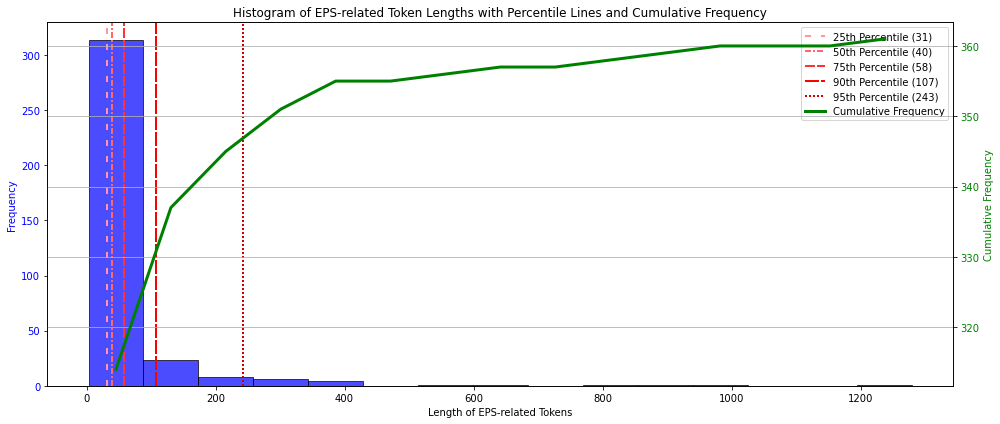

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the percentiles
percentiles = [25, 50, 75, 90, 95]
percentile_values = np.percentile(token_lengths, percentiles)

# Create the histogram and cumulative frequency
hist, bins = np.histogram(token_lengths, bins=15)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
cumulative_freq = np.cumsum(hist)

# Define different line styles and colors for each percentile
line_styles = [(0, (3, 5)), (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (7, 1)), (0, (1, 1))]
colors = ['#ff9999', '#ff6666', '#ff3333', '#ff0000', '#cc0000']

# Create the figure and the first y-axis for the histogram
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.bar(bin_centers, hist, width=bins[1] - bins[0], color='blue', alpha=0.7, edgecolor='black')
ax1.set_xlabel("Length of EPS-related Tokens")
ax1.set_ylabel("Frequency", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot percentile lines with different line styles and colors
for perc, value, style, color in zip(percentiles, percentile_values, line_styles, colors):
    ax1.axvline(value, color=color, linestyle=style, linewidth=2, label=f'{perc}th Percentile ({int(value)})')

# Create a secondary y-axis for the cumulative frequency
ax2 = ax1.twinx()
ax2.plot(bin_centers, cumulative_freq, color='green', linestyle='-', linewidth=3, label="Cumulative Frequency")
ax2.set_ylabel("Cumulative Frequency", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a legend and move it to the top right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Histogram of EPS-related Token Lengths with Percentile Lines and Cumulative Frequency")

fig.tight_layout()  # Adjust the layout to accommodate both y-axes
plt.grid(True)
plt.show()


#### Insights from the Token Length Analysis

- **Percentile-Based Analysis**: The 25th percentile is at 32 characters, the 50th percentile at 40 characters, and the 75th percentile at 59 characters. This indicates that 75% of the relevant tokens are within 59 characters.

- **Potential Cut-off Point**: Based on the percentile analysis and the cumulative frequency curve, a reasonable cut-off point for filtering relevant EPS-related tokens might be around 100 characters. This cut-off would capture about 90% of the relevant tokens while excluding the longer, less relevant descriptive sentences.

In [65]:
# Define the cut-off length
cut_off_length = 100

# Initialize counters for total before and after filtering
total_before_filtering = 0
total_after_filtering = 0

# Initialize dictionary to store the filtered EPS data
filtered_eps_data = {}

# Iterate over the files and apply the filtering
for file, eps_set in eps_data.items():
    before_count = len(eps_set)  # Count before filtering
    filtered_eps_set = {phrase for phrase in eps_set if len(phrase) <= cut_off_length}
    after_count = len(filtered_eps_set)  # Count after filtering
    
    # Store the filtered data
    filtered_eps_data[file] = filtered_eps_set
    
    # Update total counters
    total_before_filtering += before_count
    total_after_filtering += after_count
    
    # Print only the filtered EPS-related phrases
    print(f"File: {file}")
    print(f"  EPS-related phrases after filtering ({after_count}):")
    for phrase in filtered_eps_set:
        print(f"    - {phrase}")
    print("")  # Add an empty line for better readability

# Calculate the total difference
total_difference = total_before_filtering - total_after_filtering

# Print the overall results
print("Overall Summary:")
print(f"Total number of EPS-related phrases before filtering: {total_before_filtering}")
print(f"Total number of EPS-related phrases after filtering: {total_after_filtering}")
print(f"Total difference (removed): {total_difference}")



File: 0001008654-20-000048.html
  EPS-related phrases after filtering (5):
    - basic income (loss) per share
    - net income (loss) per common share:
    - diluted income (loss) per share
    - (in millions, except per share data)
    - net income (loss) per share (diluted)

File: 0001140361-20-010070.html
  EPS-related phrases after filtering (6):
    - net earnings per common share - diluted
    - net earnings per common share - basic
    - gaap diluted earnings per share from continuing operations
    - diluted earnings per share from continuing operations
    - net earnings per common share:
    - non-gaap diluted earnings per share from continuing operations

File: 0001193125-20-124288.html
  EPS-related phrases after filtering (5):
    - per share data:
    - net income per common share
    - cash dividends declared per common share
    - (in thousands, except per share data)
    - record diluted eps of $1.96, up 41% from $1.39

File: 0001299709-20-000078.html
  EPS-related ph

In [70]:
import nltk
nltk.__version__
#nltk.download('stopwords')

'3.6.5'

In [67]:
from collections import Counter
from nltk.corpus import stopwords

# Function to tokenize phrases into words
def tokenize(phrase):
    return phrase.lower().split()

# Define the set of excluded words including 'per', 'share', 'eps'
excluded_words = {"per", "share", "eps"}

# Add the standard English stop words to the excluded words
stop_words = set(stopwords.words('english'))
stop_words.update(excluded_words)

# Initialize a Counter to hold the word counts across all files
word_counter = Counter()

# Iterate over each file in the filtered EPS data
for file, eps_set in filtered_eps_data.items():
    # Create a set to hold unique words for this file
    unique_words = set()
    
    # Tokenize each phrase and add the words to the unique words set
    for phrase in eps_set:
        words = tokenize(phrase)
        unique_words.update(words)
    
    # Remove the stop words from the unique words set
    unique_words = unique_words - stop_words
    
    # Update the word counter with the unique words
    word_counter.update(unique_words)

# Get the top 10 most common words across all files
top_10_words = word_counter.most_common(10)

# Print the top 10 words and their counts
print("Top 10 Words Across All Files (Word Counts):")
for word, count in top_10_words:
    print(f"  {word}: {count}")


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/felixsun/nltk_data'
    - '/Users/felixsun/opt/anaconda3/nltk_data'
    - '/Users/felixsun/opt/anaconda3/share/nltk_data'
    - '/Users/felixsun/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
